# Variational AutoEncoder
- Generative Model이다. training data가 주어졌을 때, training data가 가지는 real 분포와 같은 분포에서 sampling된 값으로 new data를 생성하는 model을 말한다.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython.display import Image

# 0. Import Module and Load Dataset

In [3]:
from IPython import display

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


# 1. Data Preprocessing
- 784(28*28)개의 픽셀 값을 가지는 개별 이미지
- [0, 255]의 정수인 개별 픽셀 값을 0 혹은 1로 이진화 : output을 베르누이분포로 설정하기 위해.(Loss : Cross Entrophy)
    - 베르누이 확률변수 : 시행의 결과를 실수 0 또는 1로 바꾼 것.
    - 베르누이 확률분포 : 베르누이 확률변수의 분포를 따르는 확률 분포

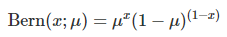

In [5]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/02/bern.png')

In [6]:
def preprocess_images(images):
  # Image Dataset을 (데이터 개수, 28, 28, 1)으로 reshape하고 255로 나누어 [0, 1] 값으로 정규화
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  # [0, 1] 값으로 정규화된 픽셀 값이 0.5보다 크면 1, 작으면 0으로 이진화
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [7]:
train_images

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [8]:
train_size = 60000
batch_size = 32
test_size = 10000

### Data Batch and Shuffle

In [9]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

# 2. Modeling

### Define Encoder and Decoder Network

Encoder Network
- 근사 사후 분포 q(z|x) : x가 주어졌을때 z가 발생할 확률
<br> → 관측 값 x를 Input으로 받는 Latent vector z의 조건부 분포를 지정하기 위한 파라미터 출력
- z분포를 Diagonal Gaussian 분포로 모델링
<br> → Gaussian의 평균과 로그 분산을 출력(수치의 안정성을 위해 로그 분산 사용)
<br> ▷ 정리하면, input data를 어떤 분포에서 나왔다고 가정하고 encoder는 input_data가 입력되면 어떤 분포의 파라미터 z_mean과 z_log_var로 변환한다.
---
Decoder Network
- p(x|z) : 위와 같은 파라미터가 주어졌을때 z를 sampling해서 x를 다시 생성하는 것이 목표
<br> → z를 입력으로 받는 관측 값 x의 조건부 분포 p(x|z)를 위한 파라미터를 출력
- prior 분포 p(z)를 Gaussian으로 모델링
<br> ▷ 정리하면, encoder를 통해 출력된 z_mean, z_log_var에서 무작위로 샘플링한 z를 얻어서 이것을 입력으로 하여 다시 이미지로 복원한다.
---
Reparameterization Trick
- Decoder에 대한 sample z를 생성하기 위해, 입력 관측 값 x가 주어졌을 때 Encoder에 의해 출력된 파라미터로 정의된 Latent space로부터 Sampling 할 수 있음
- 하지만, 역전파가 Random node를 통해 흐를 수 없기 때문에 병목 현상 발생 
- 따라서, Decoder 파라미터들 (정규분포의 평균과 표준편차)과 ε 파라미터를 이용하여 z를 근사


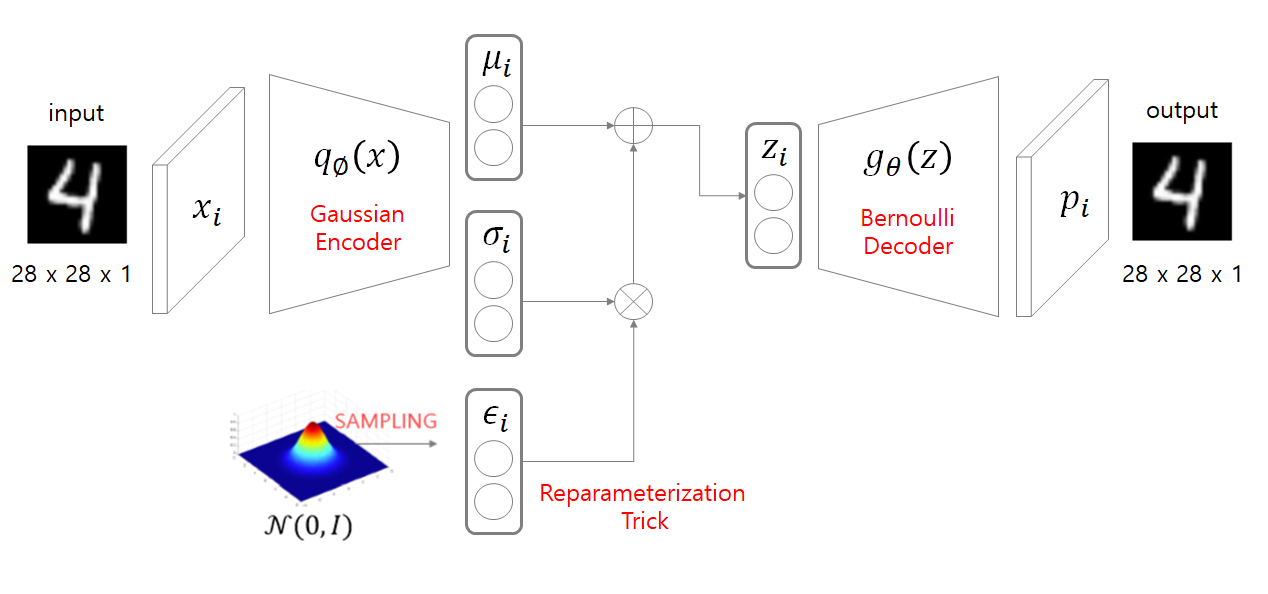

In [10]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/02/vae.png')

* q-Encoder : input image가 입력으로 들어가면 이 이미지의 각 픽셀이 가우시안 분포를 따른다고 가정하여 평균과 분산을 의미하는 두개의 값을 출력하도록 구성한다.

* g-Decoder : 이렇게 나온 출력 값인 평균과 분산의 분포에서 다시 새로운 이미지를 출력한다.

In [11]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim

###### Encoder ######
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )


###### Decoder ######
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )
# 기존의 Encoder Decoder의 구조와 동일




  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)
# random한 epsilon을 정의하는 함수


  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    # encoder의 output을 axis=1을 따라 분할
    return mean, logvar
# endoder를 통과하였을때 이후, z_mean과 log_z_var를 출력하는 함수


  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean
# random한 epsilon을 사용하여 z_mean, log_z_var에서 무작위한 z를 뽑는 함수 → model 내부에 ramdon sampling이 존재하면 BG가 불가능


  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits
# 위에서 z를 입력받아서 이미지를 생성하고 이후 sigmoid(0~1)를 통과하여 logits을 출력하는 함수

### Define Loss Function and Optimizer

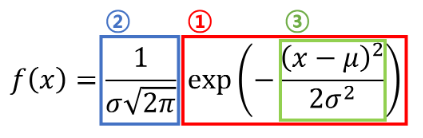

In [12]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/02/nd.png')

In [13]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)
  # log를 씌운 정규분포


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  # input data x가 encode를 통과하여 mean, logvar를 출력
  z = model.reparameterize(mean, logvar)
  # 랜덤한 epsilon을 사용하여 무작위한 z값을 뽑음
  x_logit = model.decode(z)
  # z를 decoder에 입력하여 이미지를 생성하고 이것을 다시 decode를 통과시켜 logits을 출력
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  # logit(예측)과 x(실제)의 차이를 구함.
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  # 여기까지가 reconstruction error

  # 정확히 이해하기 매우 복잡함 이러한 loss가 있다 정도로 넘어간다 #
  logpz = log_normal_pdf(z, 0., 0.)
  # loglikelihood에 적용 0, 0에 가깝도록 제한 : regularization
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)
  # crossentropy  kl_divergence  kl_divergence로 구성되어야하는데,
  # upperbound로 조정 maximize해야하는데 -를 붙여 minimize
  # 최종 값 출력
  # https://arxiv.org/pdf/1312.6114.pdf

@tf.function
def train_step(model, x, optimizer):
  """
  한 번 Training 후 Loss 값 반환.
  Loss와 Gradients를 반환하고 모델 파라미터들 업데이트 시에 사용
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### Train VAE Model

1. 반복하는 동안 매번 이미지를 Encoder로 전달하여 근사적인 사후 q(z|x)의 평균 및 로그-분산 파라미터 세트를 얻음
2. q(z|x)에서 랜덤 샘플링하기 위해 Reparameterization Trick 적용
3. 생성된 분포 p(x|z)의 로짓을 얻기 위해 Reparameterized Sample을 Decoder로 전달

In [14]:
epochs = 10
latent_dim = 2
# 시각화를 위한 latent space의 차원 설정
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
# 생성(예측)을 위한 random vector 상수 저장
model = CVAE(latent_dim)

### Generate Image

1. unit Gaussian prior 분포 p(z)에서 Latent vector set을 Sampling
2. Generator가 Latent sample z를 관측 값의 로짓으로 변환하여 분포 p(x|z)를 제공
3. Bernoulli 분포의 확률을 Plot

In [15]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  # encoder에서 평균과 분산 출력
  z = model.reparameterize(mean, logvar)
  # trick으로 랜덤하게 뽑기
  predictions = model.sample(z)
  # 다시 devoder 통과하여 출력
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    # 전체 갯수 만큼 반복하면서
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    # 예측한 이미지를 시각화
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  # 저장
  plt.show()

In [16]:
# Output images 생성을 위한 test set의 sample 선택
assert batch_size >= num_examples_to_generate
# batch_size : 32로 설정. 당연히 num_examples_to_generate보다 커야함.(한번 모델 통과 후 보여줄 사진의 갯수)
for test_batch in test_dataset.take(1):
  # 배치 1개 - 32개
  test_sample = test_batch[0:num_examples_to_generate, :, :, :] 
  # 전체 batch에서 16개만 example로 시각화

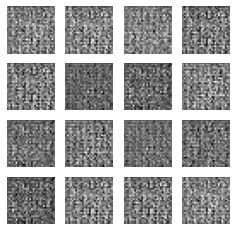

In [17]:
generate_and_save_images(model, 0, test_sample)

Epoch: 10, Test set ELBO: -153.74295043945312, time elapse for current epoch: 4.439072847366333


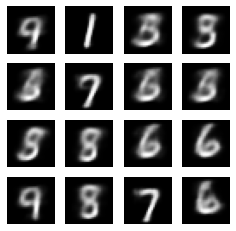

In [21]:
for epoch in range(1, epochs + 1): # 10번
  start_time = time.time()
  # 시작 시간
  for train_x in train_dataset:
    # 학습 데이터 가져와서
    train_step(model, train_x, optimizer)
    # 학습
  end_time = time.time()
  # 끝나는 시간
  loss = tf.keras.metrics.Mean()
  # loss : epoch 1번 마다의 loss
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result() 
  # -mean 이기에 커져야한다 : 세부 loss는 복잡함
  display.clear_output(wait=False) 
  # 그림도 띄우고 학습과정도 보기 위해 매 스텝마다 지우고 다시 쓰는 코드
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)
  # 샘픔 16개를 시각화

### Display a generated image from the last training epoch

In [22]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

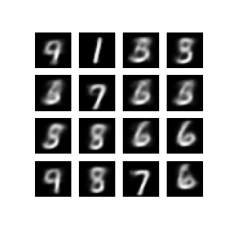

In [23]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Display a 2D manifold of digits from the latent space

In [24]:
def plot_latent_images(model, n, digit_size=28):
  """latent space로부터 decode된 이미지들 시각화."""

  norm = tfp.distributions.Normal(0, 1)
  # 정규분포 평균 0, 표준편차 1
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  # 0.05에서 0.95사이를 n개로 균일하게 뽑기
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))

  image_width = digit_size*n
  # 이미지 사이즈 x 갯수로 크게 이미지 그릴것.
  image_height = image_width
  # 높이 동일하게
  image = np.zeros((image_height, image_width))
  # 0으로 초기화

  for i, yi in enumerate(grid_x):
    # 0.05~0.95를 균일하게 뽑아서 index와 값을 가져옴
    for j, xi in enumerate(grid_y):
      # 위와 동일하게 진행
      z = np.array([[xi, yi]])
      # array로 묶어서
      x_decoded = model.sample(z)
      # model에 입력 : deocode 진행-분포에서 데이터 뽑기
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      # 전체 갯수, (원본 이미지크기)로 reshape
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()
            # 구간 구간 하나씩 이미지 시각화

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

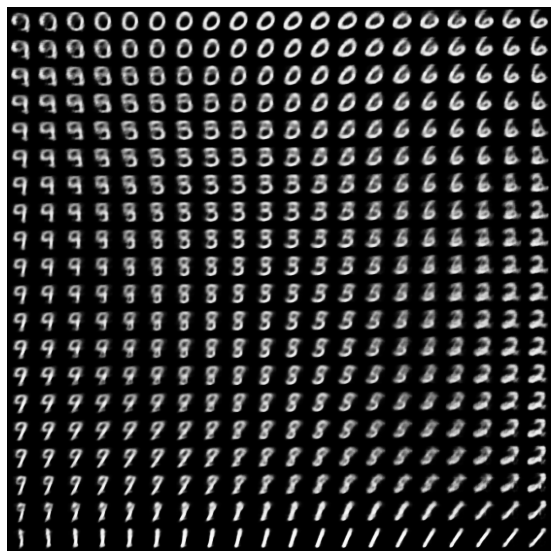

In [25]:
plot_latent_images(model, 20)

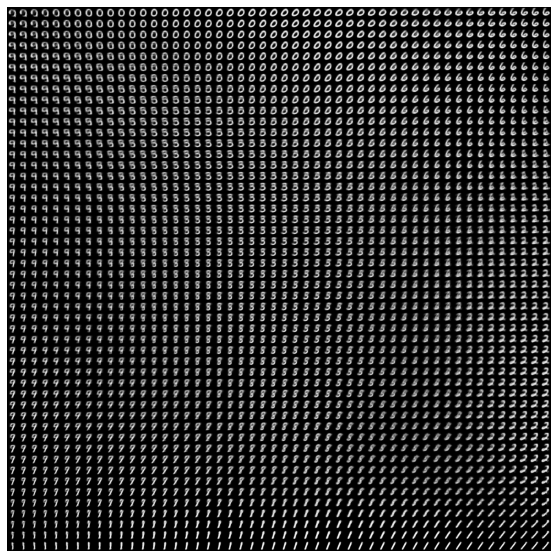

In [26]:
plot_latent_images(model, 50)